In [ ]:
!pip install -q tensorflow-text

     |████████████████████████████████| 4.3MB 10.1MB/s 


In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.6MB 7.2MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 686kB 41.7MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 174kB 51.1MB/s 
     |████████████████████████████████| 358kB 47.7MB/s 
     |████████████████████████████████| 645kB 48.8MB/s 
     |████████████████████████████████| 1.2MB 42.8MB/s 


In [ ]:
# !pip install focal_loss

In [ ]:
pip install tensorflow-addons

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from official.nlp import optimization  # to create AdamW optimizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np
# import np_utils
from keras import backend as K
# from focal_loss import BinaryFocalLoss
import matplotlib.pyplot as plt
from tensorflow.keras import activations
import tensorflow_addons as tfa


tf.get_logger().setLevel('ERROR')

In [ ]:
url = 'https://www.fing.edu.uy/inco/grupos/pln/haha/2019/data/haha_2019_train.csv'
url2 = 'https://www.fing.edu.uy/inco/grupos/pln/haha/2019/data/haha_2019_test_gold.csv'
train = pd.read_csv(url)
testG = pd.read_csv(url2)

res = np.loadtxt('PredictionsBETO.csv',delimiter=",")

# ONLY FOR REGRESSION
train = train.loc[train['is_humor'] == 1].copy()
# testG = testG.loc[testG['is_humor'] == 1].copy()


In [ ]:
testG = testG.loc[res == 1]


In [ ]:
print(testG.fillna(0))
testG = testG.fillna(0)

                       id  ... funniness_average
0     1092844370540331008  ...               0.0
2     1092537811419516933  ...               1.6
5      351113386270007297  ...               0.0
10     391589958818877440  ...               1.6
11    1052652719809298438  ...               3.4
...                   ...  ...               ...
5987  1089731325630865413  ...               2.0
5991   827492334002647040  ...               3.0
5994   937338333373583363  ...               1.4
5998   777986884895019009  ...               0.0
5999  1046698692663791616  ...               0.0

[2424 rows x 10 columns]


In [ ]:
train['funniness_average_round'] = 0.0
for i  in train.index:
  train.loc[i, 'funniness_average_round'] = round(train.loc[i, 'funniness_average'])

testG['funniness_average_round'] = 0.0
for i  in testG.index:
  testG.loc[i, 'funniness_average_round'] = round(testG.loc[i, 'funniness_average'])


In [ ]:
testG

In [ ]:
batch_size = 32
seed = 0

# Split the training 60:20:20 for TRAIN,VALID, TEST

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  #labels = dataframe.pop('is_humor') # FOR CLASSIFICATION
  labels = dataframe.pop('funniness_average') # FOR REGRESSION
  # print(dataframe)
  ds = tf.data.Dataset.from_tensor_slices(((dataframe["text"]), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

# ------------------------------------------------------------------------------------------------
#train, dev = train_test_split(train, test_size=0.2,stratify=train["is_humor"]) # FOR CLASSIFICATION
train, dev = train_test_split(train, test_size=0.2,stratify=train["funniness_average_round"]) # FOR REGRESSION

train_ds = df_to_dataset(train, batch_size=batch_size)
dev_ds = df_to_dataset(dev, batch_size=batch_size)
test_ds = df_to_dataset(testG, batch_size=batch_size)

print(train_ds)






<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.float64)>


In [ ]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'
#bert_model_name = "bert_en_cased_L-12_H-768_A-12"
#bert_model_name = "bert_en_uncased_L-12_H-768_A-12"

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))


# tf.keras.utils.plot_model(classifier_model)

tf.Tensor([[0.3230516]], shape=(1, 1), dtype=float32)


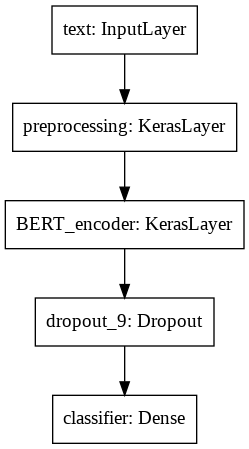

In [ ]:
def build_regression_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

regression_model = build_regression_model()
bert_raw_result = regression_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))


tf.keras.utils.plot_model(regression_model)

In [ ]:
from keras.losses import mean_squared_error

#loss = tf.keras.losses.BinaryCrossentropy(from_logits=True) # CLASSIFICATION
loss = mean_squared_error # REGRESSION


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    # print(type(y_true))
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



#metrics = [tf.metrics.BinaryAccuracy(),f1_m]  #CLASSIFICATION
metrics = [tf.metrics.RootMeanSquaredError()] #REGRESSION

In [ ]:
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps =  steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5


optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=True,
    name="RMSprop",
)

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')


history = classifier_model.fit(x=train_ds,
                               validation_data=dev_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/3
232/232 [==============================] - 254s 1s/step - loss: 0.8020 - root_mean_squared_error: 0.8956 - val_loss: 0.3991 - val_root_mean_squared_error: 0.6317
Epoch 2/3
232/232 [==============================] - 239s 1s/step - loss: 0.4086 - root_mean_squared_error: 0.6392 - val_loss: 0.3951 - val_root_mean_squared_error: 0.6286
Epoch 3/3
232/232 [==============================] - 239s 1s/step - loss: 0.3231 - root_mean_squared_error: 0.5684 - val_loss: 0.4169 - val_root_mean_squared_error: 0.6456


In [ ]:

# classifier_model.compile(optimizer=optimizer,
#                          loss=loss,
#                          metrics=metrics)
classifier_model.evaluate(test_ds)

76/76 [==============================] - 24s 321ms/step - loss: 1.0502 - root_mean_squared_error: 1.0248


[1.0502086877822876, 1.0247968435287476]

In [ ]:

pred = classifier_model.predict(test_ds)

In [ ]:

regression_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

history = regression_model.fit(x=train_ds,
                               validation_data=dev_ds,
                               epochs=epochs)

Epoch 1/2
232/232 [==============================] - 89s 377ms/step - loss: 4.1637 - root_mean_squared_error: 2.0490 - val_loss: 2.8771 - val_root_mean_squared_error: 1.6962
Epoch 2/2
232/232 [==============================] - 89s 382ms/step - loss: 2.6085 - root_mean_squared_error: 1.6151 - val_loss: 2.4059 - val_root_mean_squared_error: 1.5511


In [ ]:
pred_dev = regression_model.predict(dev_ds)

In [ ]:

pred = regression_model.predict(test_ds)


In [ ]:
print(pd.DataFrame(pred))

             0
0     0.679854
1     0.732680
2     0.914082
3     0.861506
4    -0.769100
...        ...
2337  0.574245
2338  0.766510
2339  0.510013
2340  0.848183
2341  0.553382

[2342 rows x 1 columns]


In [ ]:
classif

,id,text,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,funniness_average
1,1092537811419517056,— ¿De 15 o 20 centímetros?\n\n— Ven y averígua...,1,0,3,1,1,0,0,1.6000
3,391589958818877376,-¿Cómo te va en la clase de ortografía? -Vien ...,1,0,2,3,0,0,0,1.6000
4,1052652719809298048,"- Veo que ya tose usted mejor.\n- Sí doctor, e...",1,0,0,0,3,2,0,3.4000
5,201083222258483200,#Chiste Por qué una rubia está feliz de termin...,1,1,1,1,2,0,0,2.2500
6,752943187677831168,—Describa su vida amorosa en dos palabras. \n\...,1,0,0,2,1,2,0,3.0000
...,...,...,...,...,...,...,...,...,...,...
2417,2020341147,¿Por qué se los ángeles siempre se están riend...,1,1,0,1,2,2,0,3.2000
2418,1051534863084311040,"Psicología inversa es decirles ""¿Quieres ser m...",1,2,1,1,0,0,1,2.6667
2419,1089731325630865024,"-Oro parece plata no es, ¿qué es?\n+Bronce.\n-...",1,1,1,2,1,0,0,2.0000
2420,827492334002647040,- ¿Se quedará a dormir?\n- Sí.\n- Quizá deberí...,1,1,0,1,2,1,0,3.0000


In [ ]:
pd.merge(classif['id'], testG['id'])

,id
0,201083222258483200
1,863651240676339712
2,1050763722854227968
3,681848866090672128
4,1214679792
...,...
894,5703567335
895,672901453581709312
896,559774803037392896
897,2020341147


In [ ]:
classif = pd.read_excel('predictions_classification.xlsx')
classif = classif.loc[classif['is_humor'] == 1].copy()
print(len(testG), len(classif))

task_2_result = pred.copy()
count_mal = 0
count_ok = 0
for pos, id in enumerate(testG['id']):
  if id not in classif['id'].values:
    task_2_result[pos] = 0
    count_mal +=1
  else:
    count_ok += 1
print( count_ok, count_mal)

2342 1931
899 1443


In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error( task_2_result, testG['funniness_average'], squared = False)

1.9312603292450172

In [ ]:
classifier_model.predict(["Ponen letreros de ""Favor de no orinar fuera del inodoro"", pero ninguno de "" Favor de no cagar fuera del inodoro"". Uno no es adivino."])

array([[-0.481739]], dtype=float32)

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['root_mean_squared_error']
val_acc = history_dict['val_root_mean_squared_error']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
# f1_m = history_dict['f1_m']
# val_f1_m = history_dict['val_f1_m']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# plt.subplot(2, 1, 2)
# "bo" is for "blue dot"
# plt.plot(epochs, f1_m, 'r', label='Training F1')
# b is for "solid blue line"
# plt.plot(epochs, val_f1_m, 'b', label='Validation F1')
# plt.title('Training and validation F1_M')
# plt.xlabel('Epochs')
# plt.ylabel('F1')
# plt.legend()


In [ ]:
dataset_name = 'haha2019'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))
classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
# testtest_ds = df_to_dataset(testG, shuffle=False, batch_size=batch_size)


# from sklearn.metrics import classification_report
# import numpy as np

# Y_test = testG["is_humor"] # Convert one-hot to index
# y_pred = classifier_model.predict(testG["text"])
# y_pred_= np.argmax(y_pred,axis=1)
# print(len(y_pred_))
# print(classification_report(Y_test, y_pred_))

Resultados:


> (all with init_lr = 3e-5 and BERT uncased)


Binary Focal loss (gamma = 2)

    Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
    Epoch 1/5 
    750/750 [==============================] - 466s 608ms/step - loss: 0.6122 - binary_accuracy: 0.6730 - f1_m: 0.5779 - val_loss: 0.1386 - val_binary_accuracy: 0.7530 - val_f1_m: 0.7259
    Epoch 2/5
    750/750 [==============================] - 455s 606ms/step - loss: 0.1103 - binary_accuracy: 0.8269 - f1_m: 0.7592 - val_loss: 0.1340 - val_binary_accuracy: 0.8340 - val_f1_m: 0.7524


    Epoch 3/5
    750/750 [==============================] - 455s 607ms/step - loss: 0.0872 - binary_accuracy: 0.8699 - f1_m: 0.8202 - val_loss: 0.1419 - val_binary_accuracy: 0.8065 - val_f1_m: 0.7668


    Epoch 4/5
    750/750 [==============================] - 456s 609ms/step - loss: 0.0645 - binary_accuracy: 0.9092 - f1_m: 0.8782 - val_loss: 0.3349 - val_binary_accuracy: 0.8392 - val_f1_m: 0.7750


    Epoch 5/5
    750/750 [==============================] - 458s 611ms/step - loss: 0.0463 - binary_accuracy: 0.9397 - f1_m: 0.9201 - val_loss: 0.5019 - val_binary_accuracy: 0.8198 - val_f1_m: 0.7757


Cross-Entropy Binary

    Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
    Epoch 1/5
    750/750 [==============================] - 472s 614ms/step - loss: 0.5548 - binary_accuracy: 0.6927 - f1_m: 0.5198 - val_loss: 0.3998 - val_binary_accuracy: 0.8308 - val_f1_m: 0.7586
    Epoch 2/5
    750/750 [==============================] - 460s 614ms/step - loss: 0.3238 - binary_accuracy: 0.8553 - f1_m: 0.7768 - val_loss: 0.3931 - val_binary_accuracy: 0.8380 - val_f1_m: 0.7733
    Epoch 3/5
    750/750 [==============================] - 460s 613ms/step - loss: 0.2332 - binary_accuracy: 0.9037 - f1_m: 0.8638 - val_loss: 0.4936 - val_binary_accuracy: 0.8275 - val_f1_m: 0.7806
    Epoch 4/5
    750/750 [==============================] - 459s 611ms/step - loss: 0.1515 - binary_accuracy: 0.9438 - f1_m: 0.9220 - val_loss: 0.5540 - val_binary_accuracy: 0.8295 - val_f1_m: 0.7864
    Epoch 5/5
    750/750 [==============================] - 458s 611ms/step - loss: 0.0996 - binary_accuracy: 0.9645 - f1_m: 0.9515 - val_loss: 0.6874 - val_binary_accuracy: 0.8227 - val_f1_m: 0.7818


Cross-Entropy + Dropout of 0.3

    Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
    Epoch 1/10
    750/750 [==============================] - 472s 616ms/step - loss: 0.5454 - binary_accuracy: 0.7166 - f1_m: 0.4454 - val_loss: 0.4694 - val_binary_accuracy: 0.8042 - val_f1_m: 0.7549
    Epoch 2/10
    750/750 [==============================] - 460s 614ms/step - loss: 0.3545 - binary_accuracy: 0.8422 - f1_m: 0.7584 - val_loss: 0.3838 - val_binary_accuracy: 0.8413 - val_f1_m: 0.7715
    Epoch 3/10
    750/750 [==============================] - 461s 614ms/step - loss: 0.2585 - binary_accuracy: 0.8900 - f1_m: 0.8393 - val_loss: 0.3966 - val_binary_accuracy: 0.8412 - val_f1_m: 0.7840
    Epoch 4/10
    750/750 [==============================] - 461s 614ms/step - loss: 0.1683 - binary_accuracy: 0.9339 - f1_m: 0.9073 - val_loss: 0.5899 - val_binary_accuracy: 0.8115 - val_f1_m: 0.7748

Cross-Entropy + Dropout of 0.2 + sigmoid at the end

    Epoch 1/10
    750/750 [==============================] - 485s 618ms/step - loss: 0.6030 - binary_accuracy: 0.6634 - f1_m: 0.6106 - val_loss: 0.4388 - val_binary_accuracy: 0.8215 - val_f1_m: 0.7517
    Epoch 2/10
    750/750 [==============================] - 463s 618ms/step - loss: 0.3576 - binary_accuracy: 0.8425 - f1_m: 0.7738 - val_loss: 0.3904 - val_binary_accuracy: 0.8285 - val_f1_m: 0.7712
    Epoch 3/10
    750/750 [==============================] - 462s 617ms/step - loss: 0.2761 - binary_accuracy: 0.8858 - f1_m: 0.8422 - val_loss: 0.3971 - val_binary_accuracy: 0.8255 - val_f1_m: 0.7838
    Epoch 4/10
    750/750 [==============================] - 462s 616ms/step - loss: 0.2006 - binary_accuracy: 0.9208 - f1_m: 0.8947 - val_loss: 0.4718 - val_binary_accuracy: 0.8365 - val_f1_m: 0.7867



















    

----------------------------------------------------------------------------------------------------------------------------------------------------------------
REGRESSION


mBERT
```
Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/2
232/232 [==============================] - 253s 1s/step - loss: 0.6473 - root_mean_squared_error: 0.8046 - val_loss: 0.3888 - val_root_mean_squared_error: 0.6235
Epoch 2/2
232/232 [==============================] - 239s 1s/step - loss: 0.3913 - root_mean_squared_error: 0.6256 - val_loss: 0.3697 - val_root_mean_squared_error: 0.6080

Test
74/74 [==============================] - 25s 335ms/step - loss: 0.4119 - root_mean_squared_error: 0.6418
[0.41188693046569824, 0.6417841911315918]
```

BERT cased
```
Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/2
232/232 [==============================] - 246s 998ms/step - loss: 0.9338 - root_mean_squared_error: 0.9663 - val_loss: 0.4841 - val_root_mean_squared_error: 0.6958
Epoch 2/2
232/232 [==============================] - 230s 993ms/step - loss: 0.4256 - root_mean_squared_error: 0.6524 - val_loss: 0.3905 - val_root_mean_squared_error: 0.6249

Test

74/74 [==============================] - 25s 334ms/step - loss: 0.4212 - root_mean_squared_error: 0.6490
[0.42121851444244385, 0.6490135192871094]
```

BERT uncased
```
Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/2
232/232 [==============================] - 239s 967ms/step - loss: 0.7619 - root_mean_squared_error: 0.8729 - val_loss: 0.5172 - val_root_mean_squared_error: 0.7191
Epoch 2/2
232/232 [==============================] - 224s 966ms/step - loss: 0.4287 - root_mean_squared_error: 0.6547 - val_loss: 0.3957 - val_root_mean_squared_error: 0.6291

Test

74/74 [==============================] - 24s 321ms/step - loss: 0.4264 - root_mean_squared_error: 0.6530
[0.4264475405216217, 0.6530295014381409]

```